In [1]:
import pandas as pd
import xgboost
import shap
import RDG_interventional
import RDG_gaussian
import numpy as np
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split

In [2]:
X, y = shap.datasets.boston()

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datase

In [3]:
X = (X - np.min(X))/(np.max(X)-np.min(X))
y =  (y - np.min(y))/(np.max(y)-np.min(y))

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'


In [4]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.000000,0.18,0.067815,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680
1,0.000236,0.00,0.242302,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470
2,0.000236,0.00,0.242302,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466
3,0.000293,0.00,0.063050,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389
4,0.000705,0.00,0.063050,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.099338
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.000633,0.00,0.420455,0.0,0.386831,0.580954,0.681771,0.122671,0.000000,0.164122,0.893617,0.987619,0.219095
502,0.000438,0.00,0.420455,0.0,0.386831,0.490324,0.760041,0.105293,0.000000,0.164122,0.893617,1.000000,0.202815
503,0.000612,0.00,0.420455,0.0,0.386831,0.654340,0.907312,0.094381,0.000000,0.164122,0.893617,1.000000,0.107892
504,0.001161,0.00,0.420455,0.0,0.386831,0.619467,0.889804,0.114514,0.000000,0.164122,0.893617,0.991301,0.131071


In [5]:
feature_names = X.columns

In [6]:
correlation_matrix = pd.DataFrame(X).corr().round(2)
correlation_matrix

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46
ZN,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41
INDUS,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60
CHAS,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05
NOX,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59
RM,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61
AGE,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60
DIS,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50
RAD,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49
TAX,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54


In [7]:
X = X.values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
#clf = GradientBoostingRegressor(n_estimators=10, learning_rate=0.2,max_depth=5, random_state=0).fit(X_train, y_train)
from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=0).fit(X_train, y_train)
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(max_depth=10, random_state=0).fit(X, y)
print(clf.score(X_test, y_test))

cov = np.cov(X.T)
means = X.mean(axis=0)

minis = np.min(X,axis=0)
maxis = np.max(X,axis=0)

0.9783237067873561


In [9]:
np.mean(clf.predict(X))

0.38980208321046883

ground_truth = {}
for i in range(0,len(clf.coef_[0])):
    ground_truth[i] = np.abs(clf.coef_[0][i])
sorted_indexes = sorted(ground_truth, key=ground_truth.get,reverse=True)
sorted_indexes

In [10]:
explainer = shap.Explainer(clf)
og_shap_values = explainer(X_test)

In [11]:
og_shap_values[0]

.values =
array([ 7.42471441e-03, -2.66177928e-04, -4.39864102e-04, -9.61333981e-05,
        6.48827246e-03, -8.19592711e-02,  8.71346245e-03, -1.08769286e-02,
       -6.33800225e-03, -3.37694169e-03,  9.15991628e-03,  1.39694722e-03,
        2.64532986e-02])

.base_values =
array([0.38919719])

.data =
array([3.27751369e-04, 8.00000000e-01, 1.16568915e-01, 0.00000000e+00,
       1.44032922e-02, 4.43571565e-01, 1.66838311e-01, 7.35725523e-01,
       0.00000000e+00, 2.44274809e-01, 4.04255319e-01, 9.95662918e-01,
       2.07505519e-01])

In [12]:
explainer

In [13]:
e = shap.KernelExplainer(clf.predict, X[0:100])
ks_shap_values = e.shap_values(X_test[0:100])

  0%|          | 0/100 [00:00<?, ?it/s]

In [78]:
overall_ss_g_sum_indexes = []
overall_ss_i_sum_indexes = []
overall_ks_sum_indexes = []
overall_og_sum_indexes = []
overall_tree_sum_indexes = []

overall_ss_g_indexes = []
overall_ss_i_indexes = []
overall_ks_indexes = []
overall_og_indexes = []
overall_tree_indexes = []

ss_g_scores = []
ss_i_scores = []
ks_scores = []
og_scores = []
#tree_scores = []
for a in range(22,23):
    x = X_test[a]
    ss_i_atts,seps,nonseps = RDG_interventional.RDG(clf.predict,x,means,minis,maxis,0.06)
    ss_g_atts,seps,nonseps = RDG_gaussian.RDG(clf.predict,x,means,cov,minis,maxis,0.01,X)
    
    ks_atts = {}
    for val in range(0,len(ks_shap_values[a])):
        ks_atts[val] = ks_shap_values[a][val]
    
    og_atts = {}
    for val in range(0,len(og_shap_values[a].values)):
        og_atts[val] = og_shap_values[a].values[val]
        
    #tree_atts = {}
    #for val in range(0,len(tree_shap_values[a])):
        #tree_atts[val] = tree_shap_values[a][val]

    temp = {}
    for u in ss_i_atts.keys():
        temp[u] = np.abs(ss_i_atts[u])
    sorted_ss_i_indexes = sorted(temp, key=temp.get, reverse=True)
    
    temp = {}
    for u in ss_g_atts.keys():
        temp[u] = np.abs(ss_g_atts[u]) 
    sorted_ss_g_indexes = sorted(temp, key=temp.get, reverse=True)
    
    temp = {}
    for u in ks_atts.keys():
        temp[u] = np.abs(ks_atts[u]) 
    sorted_ks_indexes = sorted(temp, key=temp.get, reverse=True)
    
    temp = {}
    for u in og_atts.keys():
        temp[u] = np.abs(og_atts[u]) 
    sorted_og_indexes = sorted(temp, key=temp.get, reverse=True)
    
    #temp = {}
    #for u in tree_atts.keys():
       # temp[u] = np.abs(tree_atts[u]) 
    #sorted_tree_indexes = sorted(temp, key=temp.get, reverse=True)
    
    overall_ss_g_indexes.append(sorted_ss_g_indexes[0])
    overall_ss_i_indexes.append(sorted_ss_i_indexes[0])
    overall_ks_indexes.append(sorted_ks_indexes[0])
    overall_og_indexes.append(sorted_og_indexes[0])
    #overall_tree_indexes.append(sorted_tree_indexes[0])
    
    total_sum = clf.predict(x.reshape(1,-1))[0] -  clf.predict(means.reshape(1,-1))[0]

    overall_ss_i_sum_indexes.append(sum(ss_i_atts.values())[0] - total_sum)
    overall_ss_g_sum_indexes.append(sum(ss_g_atts.values())[0] - total_sum)
    overall_ks_sum_indexes.append(sum(ks_atts.values()) - total_sum)
    overall_og_sum_indexes.append(sum(og_atts.values()) - total_sum)
    
    
    ind = sorted_ss_g_indexes[0]
    new_x = x.copy()
    if len(list(ind)) > 1:
        for u in list(ind):
            new_x[u] = means[u]
    else:
        new_x[list(ind)[0]] = means[list(ind)[0]]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
    ss_g_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))
    
    ind = sorted_ss_i_indexes[0]
    new_x = x.copy()
    if len(list(ind)) > 1:
        for u in list(ind):
            new_x[u] = means[u]
    else:
        new_x[list(ind)[0]] = means[list(ind)[0]]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
    ss_i_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))
    
    ind = sorted_ks_indexes[0]
    new_x = x.copy()
    
    new_x[ind] = means[ind]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
    ks_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))
    
    
    ind = sorted_og_indexes[0]
    new_x = x.copy()
    
    new_x[ind] = means[ind]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
   
    
    og_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))
    
    
    """ind = sorted_tree_indexes[0]
    new_x = x.copy()
    
    new_x[ind] = means[ind]
    
    prediction = clf.predict(new_x.reshape(1,-1))
    
    tree_scores.append(np.abs(prediction - clf.predict(means.reshape(1,-1))))"""
            

in here



In [79]:
X.shape[0]

506

In [80]:
print('interventional')
print('sum')
print(np.mean(overall_ss_i_sum_indexes))
print(np.std(overall_ss_i_sum_indexes))

print('faithfulness')
print(np.mean(ss_i_scores))
print(np.std(ss_i_scores))

print('gaussian conditional')

print('sum')
print(np.mean(overall_ss_g_sum_indexes))
print(np.std(overall_ss_g_sum_indexes))

print('faithfulness')
print(np.mean(ss_g_scores))
print(np.std(ss_g_scores))

print('KS')

print('sum')
print(np.mean(overall_ks_sum_indexes))
print(np.std(overall_ks_sum_indexes))

print('faithfulness')
print(np.mean(ks_scores))
print(np.std(ks_scores))

print('Tree')

print('sum')
print(np.mean(overall_og_sum_indexes))
print(np.std(overall_og_sum_indexes))

print('faithfulness')
print(np.mean(og_scores))
print(np.std(og_scores))

print(" ")
print("ATTS:")

print("")

og_label_atts = {}
for i in range(0,len(feature_names)):
    og_label_atts[feature_names[i]] = og_atts[i]
print("tree atts")
print(og_label_atts)

ks_label_atts = {}
for i in range(0,len(feature_names)):
    ks_label_atts[feature_names[i]] = ks_atts[i]
print("ks atts")
print(ks_label_atts)

ss_i_atts
i_label_atts = {}
for u in ss_i_atts.keys():
    label = []
    for i in list(u):
        label.append(feature_names[i])
    i_label_atts[tuple(label)] = ss_i_atts[u][0]

print('i_label_atts')
print(i_label_atts)

ss_g_atts
g_label_atts = {}
for u in ss_g_atts.keys():
    label = []
    for i in list(u):
        label.append(feature_names[i])
    g_label_atts[tuple(label)] = ss_g_atts[u][0]
g_label_atts
print('g_label_atts')
print(g_label_atts)

interventional
sum
0.4416737221340193
0.0
faithfulness
0.1863798461083475
0.0
gaussian conditional
sum
-0.17804858229942527
0.0
faithfulness
0.003975093077359437
0.0
KS
sum
-0.02949844702282639
0.0
faithfulness
0.35624348722498617
0.0
Tree
sum
-0.029736972805428197
0.0
faithfulness
0.35624348722498617
0.0
 
ATTS:

tree atts
{'CRIM': -0.007924053226754105, 'ZN': 2.9930108298755034e-05, 'INDUS': 0.0006580176089487109, 'CHAS': -0.000323769128074497, 'NOX': 0.003250448653887676, 'RM': -0.04731392188446989, 'AGE': -0.0024990314450349057, 'DIS': 0.12669479349730148, 'RAD': 0.0004488099564117369, 'TAX': -0.0020989350527189005, 'PTRATIO': -0.006323513967326703, 'B': 0.001791441034665996, 'LSTAT': -0.2783044256413017}
ks atts
{'CRIM': -0.010327457960878745, 'ZN': 0.0009899158124903181, 'INDUS': 0.0037892317685479645, 'CHAS': 0.0, 'NOX': -0.03424195979501388, 'RM': -0.026154170136029976, 'AGE': -0.005198803031231225, 'DIS': 0.16265273020652726, 'RAD': 0.00022381125338638983, 'TAX': -0.0047307649

In [81]:
print(sorted_ss_g_indexes)
print(sorted_ss_i_indexes)
print(sorted_ks_indexes)
print(sorted_og_indexes)


[(5, 9, 10, 6, 7, 12, 11), (8,), (0,), (2,), (1,), (3,), (4,)]
[(7,), (5, 12, 9), (6,), (10,), (11,), (4,), (0,), (2,), (1,), (3,), (8,)]
[12, 7, 4, 5, 0, 6, 10, 9, 2, 11, 1, 8, 3]
[12, 7, 5, 0, 10, 4, 6, 9, 11, 2, 8, 3, 1]


In [82]:
feature_names[[0]]

Index(['CRIM'], dtype='object')

In [83]:
clf.feature_importances_

array([0.03720447, 0.00079653, 0.00518746, 0.00091909, 0.02044243,
       0.45880652, 0.01146708, 0.0648972 , 0.00302241, 0.01701131,
       0.01665616, 0.01227404, 0.3513153 ])

In [84]:
import matplotlib.pyplot as plt

In [85]:
sorted_ss_i_indexes

[(7,), (5, 12, 9), (6,), (10,), (11,), (4,), (0,), (2,), (1,), (3,), (8,)]

In [86]:
new_predictions_i = []
new_x = x.copy()
new_predictions_i.append(clf.predict(x.reshape(1,-1))[0])
for u in sorted_ss_i_indexes:
    for i in u:
        new_x[i] = means[i]
    new_predictions_i.append(clf.predict(new_x.reshape(1,-1))[0])
new_predictions_i

new_predictions_ks = []
new_x = x.copy()
new_predictions_ks.append(clf.predict(x.reshape(1,-1))[0])
for u in sorted_ks_indexes:
    new_x[u] = means[u]
    new_predictions_ks.append(clf.predict(new_x.reshape(1,-1))[0])
new_predictions_ks

[0.17728297979797986,
 0.7157037037037042,
 0.3239939189438815,
 0.3270995206133106,
 0.3311138433330927,
 0.33148164738089675,
 0.360243819751317,
 0.35998683893988237,
 0.3651151161931597,
 0.3653390440684033,
 0.359460216478718,
 0.359460216478718,
 0.359460216478718,
 0.359460216478718]

In [87]:
new_predictions_ks = []
new_x = x.copy()
new_predictions_ks.append(clf.predict(x.reshape(1,-1))[0])
for u in sorted_ks_indexes:

    new_x[u] = means[u]
    new_predictions_ks.append(clf.predict(new_x.reshape(1,-1))[0])
new_predictions_ks

[0.17728297979797986,
 0.7157037037037042,
 0.3239939189438815,
 0.3270995206133106,
 0.3311138433330927,
 0.33148164738089675,
 0.360243819751317,
 0.35998683893988237,
 0.3651151161931597,
 0.3653390440684033,
 0.359460216478718,
 0.359460216478718,
 0.359460216478718,
 0.359460216478718]

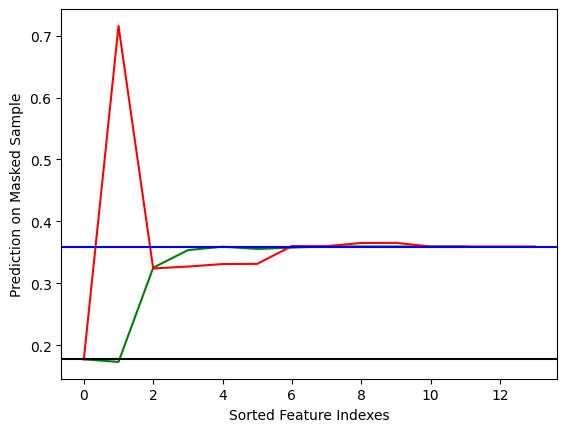

In [89]:
plt.plot(new_predictions_i,color='green')
plt.plot(new_predictions_ks,color='red')
plt.axhline(y = clf.predict(means.reshape(1,-1))[0] , color = 'blue')

plt.axhline(y = clf.predict(x.reshape(1,-1))[0] , color = 'black')
plt.xlabel('Sorted Feature Indexes')
plt.ylabel('Prediction on Masked Sample')
#plt.axvline(x = 8, color = 'green')
#plt.axvline(x = 12, color = 'red')
plt.savefig('boston23_cond.pdf')

In [51]:
temp = {}
for u in ks_label_atts.keys():
    temp[u] = np.abs(ks_label_atts[u]) 
sorted_ks_indexes = sorted(temp, key=temp.get, reverse=True)

sorted_ks_indexes

['LSTAT',
 'CRIM',
 'B',
 'RM',
 'PTRATIO',
 'AGE',
 'NOX',
 'DIS',
 'INDUS',
 'TAX',
 'RAD',
 'ZN',
 'CHAS']

In [52]:
temp = {}
for u in i_label_atts.keys():
    temp[u] = np.abs(i_label_atts[u]) 
sorted_ss_i_indexes = sorted(temp, key=temp.get, reverse=True)

sorted_ss_i_indexes

[('RM', 'LSTAT'),
 ('B',),
 ('AGE',),
 ('PTRATIO',),
 ('TAX',),
 ('CRIM',),
 ('NOX',),
 ('INDUS',),
 ('DIS',),
 ('ZN',),
 ('CHAS',),
 ('RAD',)]